In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV

np.random.seed(seed=42)

### Making a circulat data set by polar coordinates
The helper function make_circle, generates random points and by generating the theta degree from 0 to $2\pi$, returns the cartesian coordinates of points from a circular distribution. 
<br>The function make_dataset uses the generated data points by make_circle to form a dataset of two concentered circular distributions. inner circle has label $0$ and outer circle has label $1$.

In [3]:
def make_circle(mean=4, std=4, n_samples=500):
    np.random.seed(0)
    r = np.random.normal(mean, std, n_samples)
    phi = np.linspace(0,2*np.pi, len(r))
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    return x, y

In [4]:
def make_dataset(inner_mean=0, inner_std=1, inner_n=300, outer_mean=4, outer_std=0.4, outer_n=500):
    np.random.seed(0)
    inner_x, inner_y = make_circle(inner_mean, inner_std, inner_n)
    outer_x, outer_y = make_circle(outer_mean, outer_std, outer_n)
    inner = np.c_[inner_x, inner_y]
    outer = np.c_[outer_x, outer_y]
    inner_labels = np.ones((inner_n,1))
    outer_labels = np.zeros((outer_n,1))
    inner = np.hstack((inner,inner_labels))
    outer = np.hstack((outer, outer_labels))
    dataset = np.concatenate((outer, inner))
    return dataset

#### Comparing parameters of helper function make_circle

In [5]:
x_1 , y_1 = make_circle(mean=1,std=1,n_samples=500)
x_2, y_2 = make_circle(mean=4, std=0.2, n_samples=500)

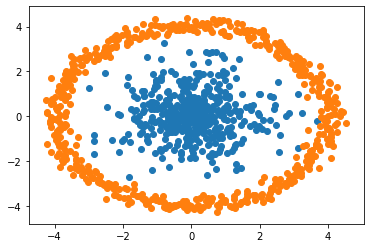

In [6]:
plt.scatter(x_1, y_1)
plt.scatter(x_2, y_2)

In [7]:
x_3 , y_3 = make_circle(mean=1,std=1,n_samples=500)
x_4, y_4 = make_circle(mean=4, std=1, n_samples=500)

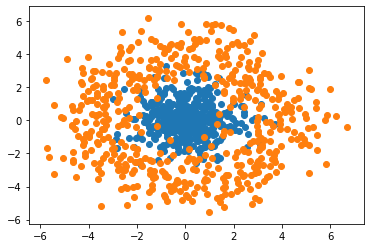

In [8]:
plt.scatter(x_3, y_3)
plt.scatter(x_4, y_4)

#### train and test set come from the same distribution with different number of samples.

In [9]:
train_set = make_dataset(inner_mean=0, inner_std=1, inner_n=100, outer_mean=4,outer_std=0.4,outer_n=300)

In [10]:
test_set = make_dataset(inner_mean=0, inner_std=1, inner_n=25, outer_mean=4, outer_std=0.4, outer_n=60)

In [11]:
train_set.shape

(400, 3)

In [12]:
test_set.shape

(85, 3)

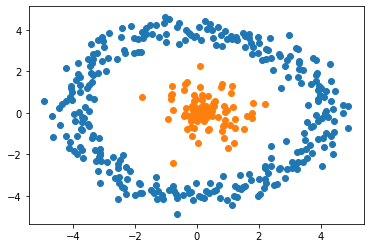

In [13]:
#plot of the training set.
plt.scatter(train_set[:300,0], train_set[:300,1])
plt.scatter(train_set[300:,0], train_set[300:,1])

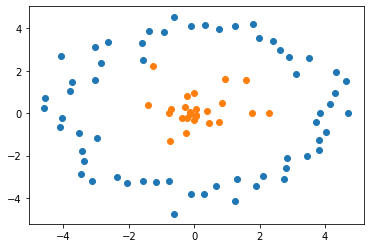

In [14]:
#plot of the test set.
plt.scatter(test_set[:60,0], test_set[:60,1])
plt.scatter(test_set[60:,0], test_set[60:,1])

#### A function to plot results of SVM

In [15]:
def plot_svc(model, ax=None, plot_support=True):

    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='B',
               levels=[-1,0,1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=100, linewidth=0.5, facecolors='none', edgecolors='k');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.show()

#### training the svm classifier

In [16]:
train_copy = np.copy(train_set)

In [17]:
#shuffle the training samples
np.random.seed(seed=42)
np.random.shuffle(train_copy)

In [18]:
#separate features and target
x_train = train_copy[:,:2]
y_train = train_copy[:,2]

In [19]:
#separate test samples and targets
x_test = test_set[:,:2]
y_test = test_set[:,2]

In [20]:
#run the svm with linear kernel 
import time
start_time = time.time()
linear_svm = SVC(C=10,kernel='linear', random_state=0)
linear_svm.fit(x_train, y_train)
print("--- model trained in %s seconds ---" % (time.time() - start_time))

--- model trained in 0.02660083770751953 seconds ---


In [21]:
y_pred_test = linear_svm.predict(x_test)

In [22]:
print(classification_report(y_test, y_pred_test, digits=4))

              precision    recall  f1-score   support

         0.0     0.7059    1.0000    0.8276        60
         1.0     0.0000    0.0000    0.0000        25

    accuracy                         0.7059        85
   macro avg     0.3529    0.5000    0.4138        85
weighted avg     0.4983    0.7059    0.5842        85



C:\Users\PC\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [43]:
len(linear_svm.support_vectors_)

211

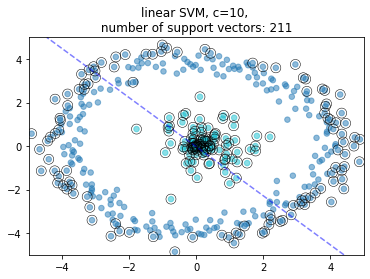

In [47]:
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.title("linear SVM, c=10, \n number of support vectors: {} " .format(len(linear_svm.support_vectors_)))
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, s=30, cmap='tab10', alpha=0.5)
plot_svc(linear_svm)

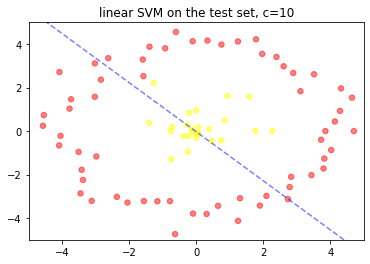

In [24]:
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.title("linear SVM on the test set, c=10")
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, s=30, cmap='autumn', alpha=0.5)
plot_svc(linear_svm,plot_support=False)

##### fitting SCM with Polynomial kernel to the training set
A RandomizedSearch is done for hyperparameter optimization

In [26]:
poly_params = { 'C':np.linspace(1e-4,10,10),
                'degree': [2,3],
                }

In [28]:
polynomial_svm = SVC(kernel='poly')
polynomial_svm_grid = RandomizedSearchCV(poly_svm_model, poly_params, cv=5)
polynomial_svm_grid.fit(x_train, y_train)

C:\Users\PC\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The defa

C:\Users\PC\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The defa

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto_deprecated',
                                 kernel='poly', max_iter=-1, probability=False,
                                 random_state=None, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'C': array([1.0000e-04, 1.1112e+00, 2.2223e+00, 3.3334e+00, 4.4445e+00,
       5.5556e+00, 6.6667e+00, 7.7778e+00, 8.8889e+00, 1.0000e+01]),
                                        'degree': [2, 3]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [29]:
polynomial_pred_test = polynomial_svm_grid.best_estimator_.predict(x_test)

In [30]:
print(classification_report(y_test, polynomial_pred_test))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        60
         1.0       1.00      1.00      1.00        25

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85



In [32]:
polynomial_svm_grid.best_estimator_

SVC(C=5.5556, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma='auto_deprecated',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

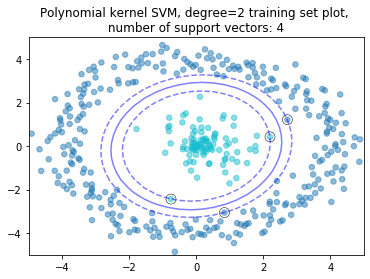

In [49]:
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.title("Polynomial kernel SVM, degree=2 training set plot, \n number of support vectors: {} " .format(len(polynomial_svm_grid.best_estimator_.support_vectors_)))
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, s=30, cmap='tab10', alpha=0.5)
plot_svc(polynomial_svm_grid.best_estimator_)

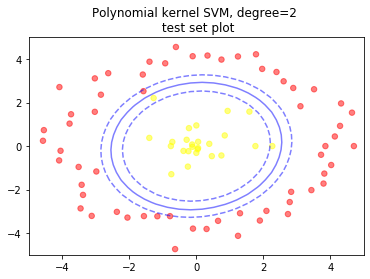

In [36]:
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.title("Polynomial kernel SVM, degree=2 \n test set plot")
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, s=30, cmap='autumn', alpha=0.5)
plot_svc(polynomial_svm_grid.best_estimator_,plot_support=False)

#### fitting SVM with rbf kernel to the training set.
A RandomizedSearch is done for hyperparameter optimization, as the data comes from a circular distribution, SVM with RBF kernel can classify all samples in the training set an test set correctly.  

In [52]:
rbf_params = {'gamma': np.linspace(0.01,10,10),
              'C':np.linspace(1e-4,10,10)
                }

In [53]:
rbf_svm = SVC(kernel='rbf')
rbf_svm_grid = RandomizedSearchCV(rbf_svm, rbf_params, cv=5)
rbf_svm_grid.fit(x_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, probability=False,
                                 random_state=None, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'C': array([1.0000e-04, 1.1112e+00, 2.2223e+00, 3.3334e+00, 4.4445e+00,
       5.5556e+00, 6.6667e+00, 7.7778e+00, 8.8889e+00, 1.0000e+01]),
                                        'gamma': array([ 0.01,  1.12,  2.23,  3.34,  4.45,  5.56,  6.67,  7.78,  8.89,
       10.  ])},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [54]:
rbf_test_pred = rbf_svm_grid.best_estimator_.predict(x_test)

In [55]:
print(classification_report(y_test,rbf_test_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        60
         1.0       1.00      1.00      1.00        25

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85



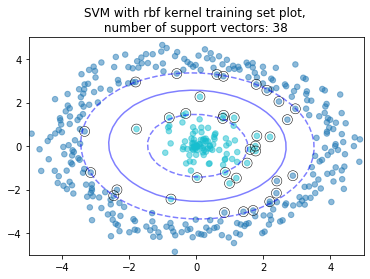

In [56]:
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.title("SVM with rbf kernel training set plot, \n number of support vectors: {} " .format(len(rbf_svm_grid.best_estimator_.support_vectors_)))
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, s=30, cmap='tab10', alpha=0.5)
plot_svc(rbf_svm_grid.best_estimator_)

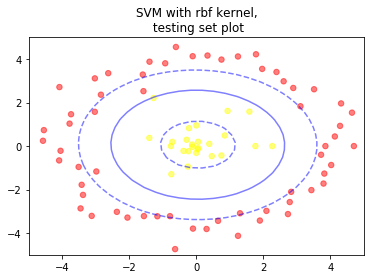

In [58]:
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.title("SVM with rbf kernel,\n testing set plot")
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, s=30, cmap='autumn', alpha=0.5)
plot_svc(rbf_svm_grid.best_estimator_, plot_support=False)